<div align="center">

#### Lab 3

# National Tsing Hua University

#### Spring 2025

#### 11320IEEM 513600

#### Deep Learning and Industrial Applications
    
## Lab 3: Anomaly Detection in Industrial Applications

</div>

### Introduction

In today's industrial landscape, the ability to detect anomalies in manufacturing processes and products is critical for maintaining quality, efficiency, and safety. This lab focuses on leveraging deep learning techniques for anomaly detection in various industrial applications, using the MVTEC Anomaly Detection Dataset. By employing ImageNet-pretrained models available in torchvision, students will gain hands-on experience in classfying defects and irregularities across different types of industrial products.

Throughout this lab, you'll be involved in the following key activities:
- Explore and process the MVTec Anomaly Detection Dataset.
- Apply ImageNet-pretrained models from [Torchvision](https://pytorch.org/vision/stable/models.html) to detect anomalies in industrial products.
- Evaluate the performance of the models to understand their effectiveness in real-world industrial applications.

### Objectives

- Understand the principles of anomaly detection in the context of industrial applications.
- Learn how to implement and utilize ImageNet-pretrained models for detecting anomalies.
- Analyze and interpret the results of the anomaly detection models to assess their practicality in industrial settings.

### Dataset

The MVTec AD Dataset is a comprehensive collection of high-resolution images across different categories of industrial products, such as bottles, cables, and metal nuts, each with various types of defects. This dataset is pivotal for developing and benchmarking anomaly detection algorithms. You can download our lab's dataset [here](https://drive.google.com/file/d/19600hUOpx0hl78TdpdH0oyy-gGTk_F_o/view?usp=share_link). You can drop downloaded data and drop to colab, or you can put into yor google drive.

### References
- [MVTec AD Dataset](https://www.kaggle.com/datasets/ipythonx/mvtec-ad/data) for the dataset used in this lab.
- [Torchvision Models](https://pytorch.org/vision/stable/models.html) for accessing ImageNet-pretrained models to be used in anomaly detection tasks.
- [State-of-the-Art Anomaly Detection on MVTec AD](https://paperswithcode.com/sota/anomaly-detection-on-mvtec-ad) for insights into the latest benchmarks and methodologies in anomaly detection applied to the MVTec AD dataset.
- [CVPR 2019: MVTec AD — A Comprehensive Real-World Dataset for Unsupervised Anomaly Detection] for the original paper of MVTec AD dataset.

In [1]:
import glob
import matplotlib.pyplot as plt
import random
from tqdm.auto import tqdm
import cv2
import numpy as np
import os

In [2]:
from google.colab import drive

drive.mount('/content/drive')

Mounted at /content/drive


In [7]:
import os
os.chdir('/content/drive/MyDrive/lab3')
file_paths = glob.glob(r'Dataset/cable/*/*/*.png')
# file_paths = sorted([path for path in file_paths if path.split('\\')[-1] in [f'{i:03}.png' for i in range(10)]])

In [8]:
all_data = []

for img in tqdm(file_paths):
    img = cv2.imread(img)
    img = img[..., ::-1]
    all_data.append(img)

all_data = np.stack(all_data)
print(all_data.shape)

  0%|          | 0/466 [00:00<?, ?it/s]

(466, 1024, 1024, 3)


In [12]:
import matplotlib.pyplot as plt
import numpy as np

classes = sorted(set([path.split('/')[2] for path in file_paths]))
print(f'Classes: {classes}')

path = 'Dataset/cable/'

# for cls in classes:
#     count = 0
#     for path in file_paths:
#         if path.split('\\')[1] == cls:
#             count += 1
#     print(f"{cls}: {count}")
for cls in classes:
    sub_path = os.path.join(path, cls)

    n = len(glob.glob(f"{sub_path}/*/*.png"))
    print(f'{cls}:{n}, {n - len(glob.glob(f"{sub_path}/good/*.png"))}')




Classes: ['ground_truth', 'test', 'train']
ground_truth:92, 92
test:150, 92
train:224, 0


## A. Data Loading and Preprocessing

In [13]:
import torch
from torch.utils.data import DataLoader, TensorDataset, random_split
import numpy as np

all_data = []
file_paths = glob.glob(r'Dataset/cable/train/*/*.png')

for img in tqdm(file_paths):
    img = cv2.imread(img)
    img = img[..., ::-1]
    all_data.append(img)

all_data = np.stack(all_data)
assert all_data.shape[0] == 224

num_classes = 2
train_n = 224

train_n = int(train_n * 0.8)
val_n = 224 - train_n

x_train = all_data[:train_n]
x_val = all_data[train_n:]


# The shape changes from (batch_size, height, width, channels) to (batch_size, channels, height, width)
x_train = np.transpose(np.array(x_train), (0, 3, 1, 2))
x_val = np.transpose(np.array(x_val), (0, 3, 1, 2))

y_train = np.ones(x_train.shape[0])
y_val = np.ones(x_val.shape[0])

print(f'Shape of x_train: {x_train.shape}')
print(f'Shape of x_val: {x_val.shape}')
print(f'Shape of y_train: {y_train.shape}')
print(f'Shape of y_val: {y_val.shape}')

  0%|          | 0/224 [00:00<?, ?it/s]

Shape of x_train: (179, 3, 1024, 1024)
Shape of x_val: (45, 3, 1024, 1024)
Shape of y_train: (179,)
Shape of y_val: (45,)


In [14]:
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, Dataset
from PIL import Image

train_transforms = transforms.Compose(
    [
        transforms.Resize((32, 32)),
        transforms.AutoAugment(),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
    ]
)

val_transforms = transforms.Compose(
    [
        transforms.Resize((32, 32)),
        transforms.ToTensor(),
    ]
)

class MyDataset(Dataset):
    def __init__(self, x, y, transform=None):
        self.x = x
        self.y = torch.from_numpy(y).long()
        self.transform = transform

    def __len__(self):
        return len(self.x)

    def __getitem__(self, idx):
        new_x = np.transpose(self.x[idx], (1, 2, 0))
        return self.transform(Image.fromarray(new_x)), self.y[idx]

In [15]:
batch_size = 4

train_dataset = MyDataset(x_train, y_train, train_transforms)
val_dataset = MyDataset(x_val, y_val, val_transforms)

train_loader = DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True, num_workers=2, pin_memory=True, persistent_workers=True)
val_loader = DataLoader(dataset=val_dataset, batch_size=batch_size, shuffle=False, num_workers=1, pin_memory=True, persistent_workers=True)

## B. Defining Neural Networks

In [16]:
import torch.nn as nn
import torch.nn.functional as F
from torchvision import models

model = models.resnet18(weights='IMAGENET1K_V1')

# ConvNet as fixed feature extractor (freeze parameters)
for param in model.parameters():
    param.requires_grad = False

num_ftrs = model.fc.in_features
num_class = 2

# change # of class from 1000 into 8 in the last layer
model.fc = nn.Linear(num_ftrs, num_class)
print(model)

Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 180MB/s]

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

## C. Training the Neural Network

In [17]:
import torch.optim as optim
from torch.optim.lr_scheduler import CosineAnnealingLR, StepLR
from tqdm.auto import tqdm

train_losses = []
val_losses = []
train_accuracies = []
val_accuracies = []

device = torch.device("cuda")

epochs = 50
model = model.to(device)

best_val_loss = float('inf')
best_val_acc = -1

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-3)
lr_scheduler = CosineAnnealingLR(optimizer, T_max=len(train_loader)*epochs, eta_min=0)

for epoch in tqdm(range(epochs)):
    # Training
    model.train()
    total_loss = 0.0
    train_correct = 0
    total_train_samples = 0

    for images, labels in train_loader:
        images = images.to(device)
        images = (images) / 255.
        labels = labels.to(device)
        optimizer.zero_grad()
        outputs = model(images)

        labels = labels.long()

        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()

        train_predicted = outputs.argmax(-1)
        train_correct += (train_predicted == labels).sum().item()
        total_train_samples += labels.size(0)

    avg_train_loss = total_loss / len(train_loader)
    train_accuracy = 100. * train_correct / total_train_samples

    # Validation
    model.eval()
    total_val_loss = 0.0
    correct = 0
    total = 0
    with torch.no_grad():
        for images, labels in val_loader:
            images = images.to(device)
            images = (images) / 255.
            labels = labels.to(device)
            outputs = model(images)

            labels = labels.long()

            loss = criterion(outputs, labels)
            total_val_loss += loss.item()

            predicted = outputs.argmax(-1)
            correct += (predicted == labels).sum().item()
            total += labels.size(0)

    avg_val_loss = total_val_loss / len(val_loader)
    val_accuracy = 100. * correct / total

    # Learning rate update
    lr_scheduler.step()

    # Checkpoint
    if avg_val_loss < best_val_loss:
        best_val_loss = avg_val_loss

    if val_accuracy > best_val_acc:
        best_val_acc = val_accuracy
        torch.save(model.state_dict(), 'model_classification.pth')

    print(f'Epoch {epoch+1}/{epochs}, Train loss: {avg_train_loss:.4f}, Train acc: {train_accuracy:.4f}%, Val loss: {avg_val_loss:.4f}, Val acc: {val_accuracy:.4f}%, Best Val loss: {best_val_loss:.4f} Best Val acc: {best_val_acc:.2f}%')

    # Store performance
    train_losses.append(avg_train_loss)
    train_accuracies.append(train_accuracy)
    val_losses.append(avg_val_loss)
    val_accuracies.append(val_accuracy)

  0%|          | 0/50 [00:00<?, ?it/s]

Epoch 1/50, Train loss: 0.1212, Train acc: 97.2067%, Val loss: 0.0000, Val acc: 100.0000%, Best Val loss: 0.0000 Best Val acc: 100.00%
Epoch 2/50, Train loss: 0.0022, Train acc: 100.0000%, Val loss: 0.0000, Val acc: 100.0000%, Best Val loss: 0.0000 Best Val acc: 100.00%
Epoch 3/50, Train loss: 0.0018, Train acc: 100.0000%, Val loss: 0.0000, Val acc: 100.0000%, Best Val loss: 0.0000 Best Val acc: 100.00%
Epoch 4/50, Train loss: 0.0028, Train acc: 100.0000%, Val loss: 0.0000, Val acc: 100.0000%, Best Val loss: 0.0000 Best Val acc: 100.00%
Epoch 5/50, Train loss: 0.0009, Train acc: 100.0000%, Val loss: 0.0000, Val acc: 100.0000%, Best Val loss: 0.0000 Best Val acc: 100.00%
Epoch 6/50, Train loss: 0.0005, Train acc: 100.0000%, Val loss: 0.0000, Val acc: 100.0000%, Best Val loss: 0.0000 Best Val acc: 100.00%
Epoch 7/50, Train loss: 0.0009, Train acc: 100.0000%, Val loss: 0.0001, Val acc: 100.0000%, Best Val loss: 0.0000 Best Val acc: 100.00%
Epoch 8/50, Train loss: 0.0008, Train acc: 100.00

### Visualizing model performance

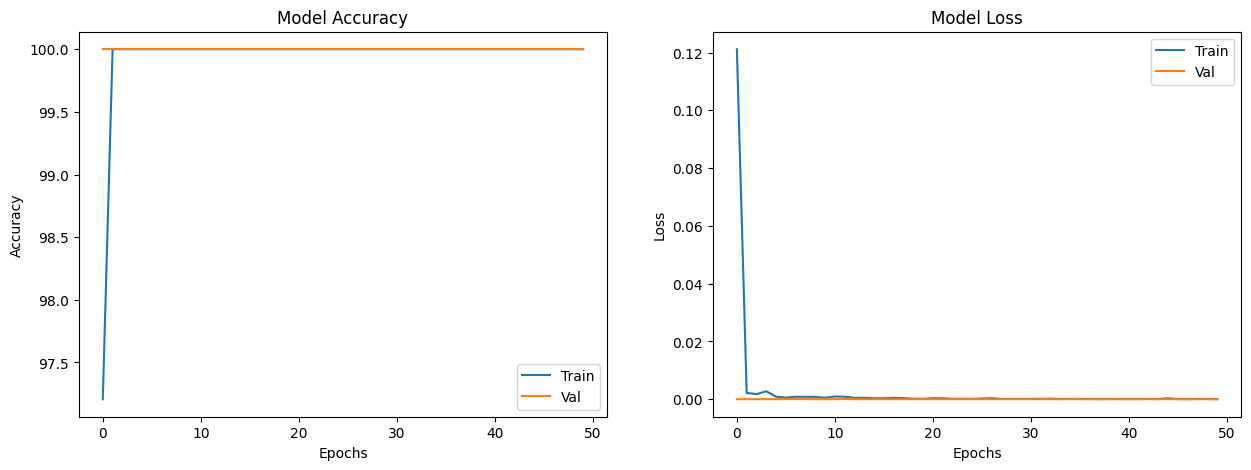

In [18]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(1, 2, figsize=(15, 5))

# Plotting training and validation accuracy
ax[0].plot(train_accuracies)
ax[0].plot(val_accuracies)
ax[0].set_title('Model Accuracy')
ax[0].set_xlabel('Epochs')
ax[0].set_ylabel('Accuracy')
ax[0].legend(['Train', 'Val'])

# Plotting training and validation loss
ax[1].plot(train_losses)
ax[1].plot(val_losses)
ax[1].set_title('Model Loss')
ax[1].set_xlabel('Epochs')
ax[1].set_ylabel('Loss')
ax[1].legend(['Train', 'Val'])

plt.show()

## D. Evaluating Your Trained Model

### Load Trained Model and Evaluate

In [23]:
# Load the trained weights
model.load_state_dict(torch.load('model_classification.pth'))

# Set the model to evaluation mode
model.eval()

test_correct = 0
test_total = 0

x_test = []
y_test = []
file_paths = glob.glob(r'Dataset/cable/test/*/*.png')

for img in tqdm(file_paths):
    if img.split('/')[3] == 'good':
      y_test.append(1)
    else:
      y_test.append(0)
    img = cv2.imread(img)
    img = img[..., ::-1]
    x_test.append(img)

x_test = np.stack(x_test)
y_test = np.array(y_test)


x_test = np.transpose(np.array(x_test), (0, 3, 1, 2))

batch_size = 4

test_dataset = MyDataset(x_test, y_test, val_transforms)
test_loader = DataLoader(dataset=test_dataset, batch_size=batch_size, shuffle=False, num_workers=1, pin_memory=True, persistent_workers=True)
with torch.no_grad():
    for images, labels in test_loader:

        images = images.cuda()
        images = (images) / 255.

        labels = labels.cuda()
        labels = labels.long()

        outputs = model(images)

        predicted = outputs.argmax(-1)
        # print(predicted)
        # print(labels)
        test_correct += (predicted == labels).sum().item()
        test_total += labels.size(0)

print(f'Test accuracy is {100. * test_correct / test_total}%')

  0%|          | 0/150 [00:00<?, ?it/s]

tensor([1, 1, 1, 1], device='cuda:0')
tensor([0, 0, 0, 0], device='cuda:0')
tensor([1, 1, 1, 1], device='cuda:0')
tensor([0, 0, 0, 0], device='cuda:0')
tensor([1, 1, 1, 1], device='cuda:0')
tensor([0, 0, 0, 0], device='cuda:0')
tensor([1, 1, 1, 1], device='cuda:0')
tensor([0, 0, 0, 0], device='cuda:0')
tensor([1, 1, 1, 1], device='cuda:0')
tensor([0, 0, 0, 0], device='cuda:0')
tensor([1, 1, 1, 1], device='cuda:0')
tensor([0, 0, 0, 0], device='cuda:0')
tensor([1, 1, 1, 1], device='cuda:0')
tensor([1, 1, 1, 1], device='cuda:0')
tensor([1, 1, 1, 1], device='cuda:0')
tensor([1, 1, 1, 1], device='cuda:0')
tensor([1, 1, 1, 1], device='cuda:0')
tensor([1, 1, 1, 1], device='cuda:0')
tensor([1, 1, 1, 1], device='cuda:0')
tensor([1, 1, 1, 1], device='cuda:0')
tensor([1, 1, 1, 1], device='cuda:0')
tensor([1, 1, 1, 1], device='cuda:0')
tensor([1, 1, 1, 1], device='cuda:0')
tensor([1, 1, 1, 1], device='cuda:0')
tensor([1, 1, 1, 1], device='cuda:0')
tensor([1, 1, 1, 1], device='cuda:0')
tensor([1, 1

# Method1 Decoder

In [32]:
import torch
import torch.nn as nn
import torchvision.models as models
import torchvision.transforms as transforms

class ResNetAutoencoder(nn.Module):
    def __init__(self, encoded_dim=512):
        super(ResNetAutoencoder, self).__init__()

        # Use pretrained ResNet18 as encoder
        resnet = models.resnet18(weights='IMAGENET1K_V1')
        self.encoder = nn.Sequential(*list(resnet.children())[:-1])  # remove fc layer
        self.flatten = nn.Flatten()

        # Decoder - you can customize this
        self.decoder = nn.Sequential(
            nn.Linear(encoded_dim, 8*8*64),
            nn.ReLU(True),
            nn.Unflatten(1, (64, 8, 8)),
            nn.ConvTranspose2d(64, 32, 4, stride=2, padding=1),  # 16x16
            nn.ReLU(True),
            nn.ConvTranspose2d(32, 3, 4, stride=2, padding=1),  # 32x32
            nn.Sigmoid()  # to keep pixel range [0, 1]
        )

    def forward(self, x):
        z = self.encoder(x)
        z = self.flatten(z)
        out = self.decoder(z)
        return out
model = ResNetAutoencoder().to(device)

In [41]:
import torch.optim as optim
from torch.optim.lr_scheduler import CosineAnnealingLR, StepLR
from tqdm.auto import tqdm

train_losses = []
val_losses = []
train_accuracies = []
val_accuracies = []

device = torch.device("cuda")

epochs = 50
model = model.to(device)

best_val_loss = float('inf')
best_val_acc = -1

criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=1e-4)
lr_scheduler = CosineAnnealingLR(optimizer, T_max=len(train_loader)*epochs, eta_min=0)

for epoch in tqdm(range(epochs)):
    # Training
    model.train()
    total_loss = 0.0
    train_correct = 0
    total_train_samples = 0
    all_reconstruction_errors = []

    for images, labels in train_loader:

        images = images.to(device)
        images = (images) / 255.
        labels = labels.to(device)
        optimizer.zero_grad()
        outputs = model(images)

        labels = labels.long()

        loss = criterion(outputs, images)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()

        error = torch.mean((outputs - images) ** 2, dim=[1, 2, 3])  # per image
        all_reconstruction_errors.extend(error.detach().cpu().numpy())
        threshold = np.percentile(all_reconstruction_errors, 95)  # e.g., top 5% as anomaly

        # Predict
        train_predicted = np.array([1 if err > threshold else 0 for err in error.detach().cpu().numpy()])
        labels_cpu = labels.detach().cpu().numpy()
        train_correct += (train_predicted == labels_cpu).sum().item()
        total_train_samples += labels.size(0)

    avg_train_loss = total_loss / len(train_loader)
    train_accuracy = 100. * train_correct / total_train_samples

    # Validation
    model.eval()
    total_val_loss = 0.0
    correct = 0
    total = 0

    with torch.no_grad():
        for images, labels in val_loader:

            images = images.to(device)
            images = (images) / 255.
            labels = labels.to(device)
            outputs = model(images)
            error = torch.mean((outputs - images) ** 2, dim=[1, 2, 3])  # per image

            predicted = np.array([1 if err > threshold else 0 for err in error.detach().cpu().numpy()])
            labels = labels.long()

            loss = criterion(outputs, images)
            total_val_loss += loss.item()
            labels_cpu = labels.detach().cpu().numpy()
            correct += (predicted == labels_cpu).sum().item()
            total += labels.size(0)

    avg_val_loss = total_val_loss / len(val_loader)
    val_accuracy = 100. * correct / total

    # Learning rate update
    lr_scheduler.step()

    # Checkpoint
    if avg_val_loss < best_val_loss:
        best_val_loss = avg_val_loss

    if val_accuracy > best_val_acc:
        best_val_acc = val_accuracy
        torch.save(model.state_dict(), 'model_classification.pth')

    print(f'Epoch {epoch+1}/{epochs}, Train loss: {avg_train_loss:.4f}, Train acc: {train_accuracy:.4f}%, Val loss: {avg_val_loss:.4f}, Val acc: {val_accuracy:.4f}%, Best Val loss: {best_val_loss:.4f} Best Val acc: {best_val_acc:.2f}%')

    # Store performance
    train_losses.append(avg_train_loss)
    train_accuracies.append(train_accuracy)
    val_losses.append(avg_val_loss)
    val_accuracies.append(val_accuracy)

  0%|          | 0/50 [00:00<?, ?it/s]

Epoch 1/50, Train loss: 0.0157, Train acc: 1.6760%, Val loss: 0.0028, Val acc: 0.0000%, Best Val loss: 0.0028 Best Val acc: 0.00%
Epoch 2/50, Train loss: 0.0012, Train acc: 2.7933%, Val loss: 0.0003, Val acc: 0.0000%, Best Val loss: 0.0003 Best Val acc: 0.00%
Epoch 3/50, Train loss: 0.0003, Train acc: 3.9106%, Val loss: 0.0001, Val acc: 0.0000%, Best Val loss: 0.0001 Best Val acc: 0.00%
Epoch 4/50, Train loss: 0.0002, Train acc: 5.0279%, Val loss: 0.0000, Val acc: 0.0000%, Best Val loss: 0.0000 Best Val acc: 0.00%
Epoch 5/50, Train loss: 0.0001, Train acc: 3.3520%, Val loss: 0.0000, Val acc: 2.2222%, Best Val loss: 0.0000 Best Val acc: 2.22%
Epoch 6/50, Train loss: 0.0001, Train acc: 6.1453%, Val loss: 0.0000, Val acc: 0.0000%, Best Val loss: 0.0000 Best Val acc: 2.22%
Epoch 7/50, Train loss: 0.0000, Train acc: 5.0279%, Val loss: 0.0000, Val acc: 0.0000%, Best Val loss: 0.0000 Best Val acc: 2.22%
Epoch 8/50, Train loss: 0.0000, Train acc: 4.4693%, Val loss: 0.0000, Val acc: 2.2222%, Be

In [42]:
# Load the trained weights
model.load_state_dict(torch.load('model_classification.pth'))

# Set the model to evaluation mode
model.eval()

test_correct = 0
test_total = 0

x_test = []
y_test = []
file_paths = glob.glob(r'Dataset/cable/test/*/*.png')

for img in tqdm(file_paths):
    if img.split('/')[3] == 'good':
      y_test.append(1)
    else:
      y_test.append(0)
    img = cv2.imread(img)
    img = img[..., ::-1]
    x_test.append(img)

x_test = np.stack(x_test)
y_test = np.array(y_test)


x_test = np.transpose(np.array(x_test), (0, 3, 1, 2))

batch_size = 4

test_dataset = MyDataset(x_test, y_test, val_transforms)
test_loader = DataLoader(dataset=test_dataset, batch_size=batch_size, shuffle=False, num_workers=1, pin_memory=True, persistent_workers=True)
with torch.no_grad():
    for images, labels in test_loader:
        reconstruction_errors = []
        images = images.to(device)
        images = (images) / 255.
        labels = labels.to(device)
        outputs = model(images)
        error = torch.mean((outputs - images) ** 2, dim=[1, 2, 3])  # per image
        #reconstruction_errors.extend(error.detach().cpu().numpy())
        #threshold = np.percentile(reconstruction_errors, 95)  # e.g., top 5% as anomaly

        predicted = np.array([1 if err > threshold else 0 for err in error.detach().cpu().numpy()])
        labels = labels.long()

        loss = criterion(outputs, images)

        labels_cpu = labels.detach().cpu().numpy()
        test_correct += (predicted == labels_cpu).sum().item()
        test_total += labels.size(0)

print(f'Test accuracy is {100. * test_correct / test_total}%')

  0%|          | 0/150 [00:00<?, ?it/s]

Test accuracy is 40.666666666666664%


# Method2 Decoder with Deeper Network

In [46]:
import torch
import torch.nn as nn
import torchvision.models as models
import torchvision.transforms as transforms

class ResNetAutoencoder(nn.Module):
    def __init__(self, encoded_dim=512):
        super(ResNetAutoencoder, self).__init__()

        # Use pretrained ResNet50 as encoder
        resnet = models.resnet50(weights='IMAGENET1K_V1')
        self.encoder = nn.Sequential(*list(resnet.children())[:-1])  # remove fc layer
        self.flatten = nn.Flatten()

        # Decoder - you can customize this
        self.decoder = nn.Sequential(
            nn.Linear(encoded_dim, 8*8*64),
            nn.ReLU(True),
            nn.Unflatten(1, (64, 8, 8)),
            nn.ConvTranspose2d(64, 32, 4, stride=2, padding=1),  # 16x16
            nn.ReLU(True),
            nn.ConvTranspose2d(32, 3, 4, stride=2, padding=1),  # 32x32
            nn.Sigmoid()  # to keep pixel range [0, 1]
        )

    def forward(self, x):
        z = self.encoder(x)
        z = self.flatten(z)
        out = self.decoder(z)
        return out
model = ResNetAutoencoder(encoded_dim=2048).to(device)

In [47]:
import torch.optim as optim
from torch.optim.lr_scheduler import CosineAnnealingLR, StepLR
from tqdm.auto import tqdm

train_losses = []
val_losses = []
train_accuracies = []
val_accuracies = []

device = torch.device("cuda")

epochs = 50
model = model.to(device)

best_val_loss = float('inf')
best_val_acc = -1

criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=1e-4)
lr_scheduler = CosineAnnealingLR(optimizer, T_max=len(train_loader)*epochs, eta_min=0)

for epoch in tqdm(range(epochs)):
    # Training
    model.train()
    total_loss = 0.0
    train_correct = 0
    total_train_samples = 0
    all_reconstruction_errors = []

    for images, labels in train_loader:

        images = images.to(device)
        images = (images) / 255.
        labels = labels.to(device)
        optimizer.zero_grad()
        outputs = model(images)

        labels = labels.long()

        loss = criterion(outputs, images)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()

        error = torch.mean((outputs - images) ** 2, dim=[1, 2, 3])  # per image
        all_reconstruction_errors.extend(error.detach().cpu().numpy())
        threshold = np.percentile(all_reconstruction_errors, 95)  # e.g., top 5% as anomaly

        # Predict
        train_predicted = np.array([1 if err > threshold else 0 for err in error.detach().cpu().numpy()])
        labels_cpu = labels.detach().cpu().numpy()
        train_correct += (train_predicted == labels_cpu).sum().item()
        total_train_samples += labels.size(0)

    avg_train_loss = total_loss / len(train_loader)
    train_accuracy = 100. * train_correct / total_train_samples

    # Validation
    model.eval()
    total_val_loss = 0.0
    correct = 0
    total = 0

    with torch.no_grad():
        for images, labels in val_loader:

            images = images.to(device)
            images = (images) / 255.
            labels = labels.to(device)
            outputs = model(images)
            error = torch.mean((outputs - images) ** 2, dim=[1, 2, 3])  # per image

            predicted = np.array([1 if err > threshold else 0 for err in error.detach().cpu().numpy()])
            labels = labels.long()

            loss = criterion(outputs, images)
            total_val_loss += loss.item()
            labels_cpu = labels.detach().cpu().numpy()
            correct += (predicted == labels_cpu).sum().item()
            total += labels.size(0)

    avg_val_loss = total_val_loss / len(val_loader)
    val_accuracy = 100. * correct / total

    # Learning rate update
    lr_scheduler.step()

    # Checkpoint
    if avg_val_loss < best_val_loss:
        best_val_loss = avg_val_loss

    if val_accuracy > best_val_acc:
        best_val_acc = val_accuracy
        torch.save(model.state_dict(), 'model_classification.pth')

    print(f'Epoch {epoch+1}/{epochs}, Train loss: {avg_train_loss:.4f}, Train acc: {train_accuracy:.4f}%, Val loss: {avg_val_loss:.4f}, Val acc: {val_accuracy:.4f}%, Best Val loss: {best_val_loss:.4f} Best Val acc: {best_val_acc:.2f}%')

    # Store performance
    train_losses.append(avg_train_loss)
    train_accuracies.append(train_accuracy)
    val_losses.append(avg_val_loss)
    val_accuracies.append(val_accuracy)

  0%|          | 0/50 [00:00<?, ?it/s]

Epoch 1/50, Train loss: 0.1718, Train acc: 0.5587%, Val loss: 0.0536, Val acc: 0.0000%, Best Val loss: 0.0536 Best Val acc: 0.00%
Epoch 2/50, Train loss: 0.0195, Train acc: 1.1173%, Val loss: 0.0003, Val acc: 0.0000%, Best Val loss: 0.0003 Best Val acc: 0.00%
Epoch 3/50, Train loss: 0.0021, Train acc: 1.1173%, Val loss: 0.0011, Val acc: 0.0000%, Best Val loss: 0.0003 Best Val acc: 0.00%
Epoch 4/50, Train loss: 0.0006, Train acc: 3.3520%, Val loss: 0.0002, Val acc: 0.0000%, Best Val loss: 0.0002 Best Val acc: 0.00%
Epoch 5/50, Train loss: 0.0003, Train acc: 3.3520%, Val loss: 0.0002, Val acc: 6.6667%, Best Val loss: 0.0002 Best Val acc: 6.67%
Epoch 6/50, Train loss: 0.0002, Train acc: 3.9106%, Val loss: 0.0001, Val acc: 8.8889%, Best Val loss: 0.0001 Best Val acc: 8.89%
Epoch 7/50, Train loss: 0.0001, Train acc: 3.3520%, Val loss: 0.0001, Val acc: 11.1111%, Best Val loss: 0.0001 Best Val acc: 11.11%
Epoch 8/50, Train loss: 0.0001, Train acc: 3.9106%, Val loss: 0.0001, Val acc: 20.0000%,

In [48]:
# Load the trained weights
model.load_state_dict(torch.load('model_classification.pth'))

# Set the model to evaluation mode
model.eval()

test_correct = 0
test_total = 0

x_test = []
y_test = []
file_paths = glob.glob(r'Dataset/cable/test/*/*.png')

for img in tqdm(file_paths):
    if img.split('/')[3] == 'good':
      y_test.append(1)
    else:
      y_test.append(0)
    img = cv2.imread(img)
    img = img[..., ::-1]
    x_test.append(img)

x_test = np.stack(x_test)
y_test = np.array(y_test)


x_test = np.transpose(np.array(x_test), (0, 3, 1, 2))

batch_size = 4

test_dataset = MyDataset(x_test, y_test, val_transforms)
test_loader = DataLoader(dataset=test_dataset, batch_size=batch_size, shuffle=False, num_workers=1, pin_memory=True, persistent_workers=True)
with torch.no_grad():
    for images, labels in test_loader:
        reconstruction_errors = []
        images = images.to(device)
        images = (images) / 255.
        labels = labels.to(device)
        outputs = model(images)
        error = torch.mean((outputs - images) ** 2, dim=[1, 2, 3])  # per image
        #reconstruction_errors.extend(error.detach().cpu().numpy())
        #threshold = np.percentile(reconstruction_errors, 95)  # e.g., top 5% as anomaly

        predicted = np.array([1 if err > threshold else 0 for err in error.detach().cpu().numpy()])
        labels = labels.long()

        loss = criterion(outputs, images)

        labels_cpu = labels.detach().cpu().numpy()
        test_correct += (predicted == labels_cpu).sum().item()
        test_total += labels.size(0)

print(f'Test accuracy is {100. * test_correct / test_total}%')

  0%|          | 0/150 [00:00<?, ?it/s]

Test accuracy is 47.333333333333336%


# Method3 Decoder

In [49]:
pip install pytorch-msssim

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 73.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 23.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 49.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 808.9 kB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 2.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 16.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 4.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 7.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 35.2 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninstalling nvidia-nvjitlink-cu12-12.5.82:
      Successfully uninstalled nvidia-nvjitl

In [57]:
import torch.optim as optim
from torch.optim.lr_scheduler import CosineAnnealingLR, StepLR
from tqdm.auto import tqdm
from pytorch_msssim import ssim

def ssim_loss(pred, target):
    return 1 - ssim(pred, target, data_range=1.0, size_average=True)

train_losses = []
val_losses = []
train_accuracies = []
val_accuracies = []
model = ResNetAutoencoder(encoded_dim=2048).to(device)
device = torch.device("cuda")

epochs = 5
model = model.to(device)

best_val_loss = float('inf')
best_val_acc = -1

mse = nn.MSELoss()
def combined_loss(pred, target):
    return 0.5 * mse(pred, target) + 0.5 * ssim_loss(pred, target)
optimizer = optim.Adam(model.parameters(), lr=1e-4)
lr_scheduler = CosineAnnealingLR(optimizer, T_max=len(train_loader)*epochs, eta_min=0)

for epoch in tqdm(range(epochs)):
    # Training
    model.train()
    total_loss = 0.0
    train_correct = 0
    total_train_samples = 0
    all_reconstruction_errors = []

    for images, labels in train_loader:

        images = images.to(device)
        images = (images) / 255.
        labels = labels.to(device)
        optimizer.zero_grad()
        outputs = model(images)

        labels = labels.long()

        loss = combined_loss(outputs, images)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()

        error = torch.mean((outputs - images) ** 2, dim=[1, 2, 3])  # per image
        all_reconstruction_errors.extend(error.detach().cpu().numpy())
        threshold = np.percentile(all_reconstruction_errors, 95)  # e.g., top 5% as anomaly

        # Predict
        train_predicted = np.array([1 if err > threshold else 0 for err in error.detach().cpu().numpy()])
        labels_cpu = labels.detach().cpu().numpy()
        train_correct += (train_predicted == labels_cpu).sum().item()
        total_train_samples += labels.size(0)

    avg_train_loss = total_loss / len(train_loader)
    train_accuracy = 100. * train_correct / total_train_samples

    # Validation
    model.eval()
    total_val_loss = 0.0
    correct = 0
    total = 0

    with torch.no_grad():
        for images, labels in val_loader:

            images = images.to(device)
            images = (images) / 255.
            labels = labels.to(device)
            outputs = model(images)
            error = torch.mean((outputs - images) ** 2, dim=[1, 2, 3])  # per image

            predicted = np.array([1 if err > threshold else 0 for err in error.detach().cpu().numpy()])
            labels = labels.long()

            loss = combined_loss(outputs, images)
            total_val_loss += loss.item()
            labels_cpu = labels.detach().cpu().numpy()
            correct += (predicted == labels_cpu).sum().item()
            total += labels.size(0)

    avg_val_loss = total_val_loss / len(val_loader)
    val_accuracy = 100. * correct / total

    # Learning rate update
    lr_scheduler.step()

    # Checkpoint
    if avg_val_loss < best_val_loss:
        best_val_loss = avg_val_loss

    if val_accuracy > best_val_acc:
        best_val_acc = val_accuracy
        torch.save(model.state_dict(), 'model_classification.pth')

    print(f'Epoch {epoch+1}/{epochs}, Train loss: {avg_train_loss:.4f}, Train acc: {train_accuracy:.4f}%, Val loss: {avg_val_loss:.4f}, Val acc: {val_accuracy:.4f}%, Best Val loss: {best_val_loss:.4f} Best Val acc: {best_val_acc:.2f}%')

    # Store performance
    train_losses.append(avg_train_loss)
    train_accuracies.append(train_accuracy)
    val_losses.append(avg_val_loss)
    val_accuracies.append(val_accuracy)

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch 1/5, Train loss: 0.5627, Train acc: 0.5587%, Val loss: 0.2095, Val acc: 0.0000%, Best Val loss: 0.2095 Best Val acc: 0.00%
Epoch 2/5, Train loss: 0.1994, Train acc: 2.7933%, Val loss: 0.0205, Val acc: 0.0000%, Best Val loss: 0.0205 Best Val acc: 0.00%
Epoch 3/5, Train loss: 0.0187, Train acc: 1.1173%, Val loss: 0.0106, Val acc: 0.0000%, Best Val loss: 0.0106 Best Val acc: 0.00%
Epoch 4/5, Train loss: 0.0110, Train acc: 1.6760%, Val loss: 0.0079, Val acc: 0.0000%, Best Val loss: 0.0079 Best Val acc: 0.00%
Epoch 5/5, Train loss: 0.0088, Train acc: 5.0279%, Val loss: 0.0108, Val acc: 13.3333%, Best Val loss: 0.0079 Best Val acc: 13.33%


In [58]:
# Load the trained weights
model.load_state_dict(torch.load('model_classification.pth'))

# Set the model to evaluation mode
model.eval()

test_correct = 0
test_total = 0

x_test = []
y_test = []
file_paths = glob.glob(r'Dataset/cable/test/*/*.png')

for img in tqdm(file_paths):
    if img.split('/')[3] == 'good':
      y_test.append(1)
    else:
      y_test.append(0)
    img = cv2.imread(img)
    img = img[..., ::-1]
    x_test.append(img)

x_test = np.stack(x_test)
y_test = np.array(y_test)


x_test = np.transpose(np.array(x_test), (0, 3, 1, 2))

batch_size = 4

test_dataset = MyDataset(x_test, y_test, val_transforms)
test_loader = DataLoader(dataset=test_dataset, batch_size=batch_size, shuffle=False, num_workers=1, pin_memory=True, persistent_workers=True)
with torch.no_grad():
    for images, labels in test_loader:
        reconstruction_errors = []
        images = images.to(device)
        images = (images) / 255.
        labels = labels.to(device)
        outputs = model(images)
        error = torch.mean((outputs - images) ** 2, dim=[1, 2, 3])  # per image
        #reconstruction_errors.extend(error.detach().cpu().numpy())
        #threshold = np.percentile(reconstruction_errors, 95)  # e.g., top 5% as anomaly

        predicted = np.array([1 if err > threshold else 0 for err in error.detach().cpu().numpy()])
        labels = labels.long()


        labels_cpu = labels.detach().cpu().numpy()
        test_correct += (predicted == labels_cpu).sum().item()
        test_total += labels.size(0)

print(f'Test accuracy is {100. * test_correct / test_total}%')

  0%|          | 0/150 [00:00<?, ?it/s]

Test accuracy is 56.0%


# Method4  Deep SVDD

In [59]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import models

# Step 1: Define the encoder
class ResNetEncoder(nn.Module):
    def __init__(self, encoded_dim=2048):
        super().__init__()
        resnet = models.resnet50(weights='IMAGENET1K_V1')
        self.feature_extractor = nn.Sequential(*list(resnet.children())[:-1])  # remove fc layer
        self.flatten = nn.Flatten()

    def forward(self, x):
        x = self.feature_extractor(x)
        x = self.flatten(x)  # [batch, 2048]
        return x
class DeepSVDDTrainer:
    def __init__(self, model, device, nu=0.1):
        self.model = model.to(device)
        self.device = device
        self.nu = nu
        self.c = None  # center of hypersphere

    def initialize_center(self, dataloader):
        """ Compute the mean of encoded features for center c """
        self.model.eval()
        n_samples = 0
        c = torch.zeros(self.model(torch.zeros(1, 3, 224, 224).to(self.device)).shape[1], device=self.device)

        with torch.no_grad():
            for x, _ in dataloader:
                x = x.to(self.device)
                x = x / 255.
                z = self.model(x)
                n_samples += z.shape[0]
                c += torch.sum(z, dim=0)

        c /= n_samples

        # If any dimension is close to 0, adjust it slightly to avoid trivial solutions
        c[c.abs() < 1e-6] = 1e-6
        self.c = c

    def train(self, dataloader, lr=1e-4, epochs=50):
        optimizer = torch.optim.Adam(self.model.parameters(), lr=lr)
        self.model.train()

        for epoch in range(epochs):
            total_loss = 0
            for x, _ in dataloader:
                x = x.to(self.device)
                x = x / 255.
                z = self.model(x)
                dist = torch.sum((z - self.c) ** 2, dim=1)  # squared L2 distance
                loss = torch.mean(dist)
                optimizer.zero_grad()
                loss.backward()
                optimizer.step()
                total_loss += loss.item()

            print(f"Epoch {epoch+1}/{epochs}, Loss: {total_loss / len(dataloader):.4f}")
def get_anomaly_scores(model, dataloader, center, device):
    model.eval()
    scores = []

    with torch.no_grad():
        for x, _ in dataloader:
            x = x.to(device)
            x = x / 255.
            z = model(x)
            dist = torch.sum((z - center) ** 2, dim=1)
            scores.extend(dist.cpu().numpy())

    return scores


In [60]:
device = torch.device("cuda")
encoder = ResNetEncoder(encoded_dim=2048)
svdd = DeepSVDDTrainer(encoder, device)

svdd.initialize_center(train_loader)
svdd.train(train_loader, lr=1e-4, epochs=50)

train_scores = get_anomaly_scores(svdd.model, train_loader, svdd.c, device)
test_scores = get_anomaly_scores(svdd.model, test_loader, svdd.c, device)

Epoch 1/50, Loss: 2529.4237
Epoch 2/50, Loss: 2294.9292
Epoch 3/50, Loss: 2168.3094
Epoch 4/50, Loss: 2089.4182
Epoch 5/50, Loss: 2001.2634
Epoch 6/50, Loss: 1942.7500
Epoch 7/50, Loss: 1896.0767
Epoch 8/50, Loss: 1844.3960
Epoch 9/50, Loss: 1788.2928
Epoch 10/50, Loss: 1761.3425
Epoch 11/50, Loss: 1740.0809
Epoch 12/50, Loss: 1698.4956
Epoch 13/50, Loss: 1660.6462
Epoch 14/50, Loss: 1644.9318
Epoch 15/50, Loss: 1640.8890
Epoch 16/50, Loss: 1621.3659
Epoch 17/50, Loss: 1605.5950
Epoch 18/50, Loss: 1573.5252
Epoch 19/50, Loss: 1543.6626
Epoch 20/50, Loss: 1533.3108
Epoch 21/50, Loss: 1527.2842
Epoch 22/50, Loss: 1512.1880
Epoch 23/50, Loss: 1486.1798
Epoch 24/50, Loss: 1476.5364
Epoch 25/50, Loss: 1481.2676
Epoch 26/50, Loss: 1448.0856
Epoch 27/50, Loss: 1438.8700
Epoch 28/50, Loss: 1418.6276
Epoch 29/50, Loss: 1410.0087
Epoch 30/50, Loss: 1397.1164
Epoch 31/50, Loss: 1381.1227
Epoch 32/50, Loss: 1364.3849
Epoch 33/50, Loss: 1354.4787
Epoch 34/50, Loss: 1344.1111
Epoch 35/50, Loss: 1338

In [61]:
threshold = np.percentile(train_scores, 95)

# Predict
predicted = np.array([1 if score > threshold else 0 for score in test_scores])

In [63]:
accuracy = 100. * np.sum(predicted == y_test) / len(y_test)
print(f'Test accuracy is {accuracy}%')

Test accuracy is 61.333333333333336%
